# CIS5450
## Michael's (my) part of the project: Spotify API + ML

**Team & Responsibilities**
*  Michael Li (API Wrangling, ML Model Building, and Writing)
*  Crystal Dai (Data Cleaning, Visualizations, and Writing)
*  Andrew Wu (Data Cleaning, Fine Tuning, and Writing)

Note to the TAs: there are many cells that are not runnable (written in MarkDown instead of the code space). This is due to an issue with Spotify API and its rate limiting. We will further explain later in the notebook, but these are just there to show how we got to the dataset we trained our models on.

---

# PURPOSE

The goal of this project is to predict whether songs will be top hits/popular (defined as high amounts of appearances on the top boards) in the US, the UK, both, or neither. We intend to do this by hooking up Spotify's API to get audutory information and then training models on that information to make our predictions.

# SETUP
First, we imported the necessary libraries.

In [5]:
# Imported necessary libraries.
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

Then, we connected to the necessary APIs.

In [6]:
#Set up Spotify API.
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Obtained API credentials (Client ID and Client Secret) from the Spotify Developer Dashboard.
client_id = '03a76ddd563b4e069606cf0dc5d38bc5'
client_secret = 'b1a6f81a31634c019935856da835565c'

# Created new instance of the Spotify client credentials manager.
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)

# Created a new instance of the Spotipy API.
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Finally, we downloaded the necessary data set from Kaggle. This dataset has all the "Top 200" and "Viral 50" charts published globally by Spotify. Spotify publishes a new chart every 2-3 days. This is its entire collection since January 1, 2017. You can access this dataset at https://www.kaggle.com/datasets/dhruvildave/spotify-charts.

```
# Mounted drive and signed in.
from google.colab import drive
drive.mount('/content/drive')

# Imported dataset directly from Kaggle as it was too large to upload directly.
! pip install -q kaggle
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!!kaggle datasets download -d dhruvildave/spotify-charts
!unzip /content/spotify-charts.zip
```



# EDA

Then, we did some preprocessing and EDA.

Note to TAs: many cells in the data preprocessing section are in text markdown cells. Unfortunately, it is impossible to run our entire EDA and cleaning process from start to finish in one Colab notebook due to our use of the Spotify API. Our dataset that we passed into the API contained 23,000 records, and we found that the limit per Colab/Spotify account was between 6000 and 9000 records (which is also the reason why our dataset is a little smaller - it would be an incredibly inefficient use of time and resources to make 5-10 different Spotify accounts and different Gmails to open and run the Colab Notebooks). To be safe, we cut the dataset into four pieces of around 6,000 each and ran it on four separate Spotify accounts and emails (had to make a burner Spotify account for it). We then saved each of the 6,000 record sets from each account as CSVs and directly read them here. Since it's not really practical to re-run the Spotify API with 4 more accounts and around 70 minutes of runtime (Spotify API usually can run up to 6 songs per second), we will simply show you the code that we used to do the preprocessing even if it is not runnable.

## Data Cleaning

We first narrowed our focus towards the amount of times each song appeared on the charts. Note that we dropped any records with more than 913 appearances because this dataset was updated every 2 to 3 days across 5 years, and thus 913 is the maximum amount of times one song could appear here (5 * 365 / 2).



```
# Loaded dataset from the original Kaggle download.
spotify_df = pd.read_csv("charts.csv")

# Dropped some unnecessary columns.
spotify_cleaned = spotify_df.drop(['date','chart', 'trend'], axis = 1)

# Selected only rows from our regions of interest.
spotify_US = spotify_cleaned[spotify_cleaned['region'] == 'United States']
spotify_UK = spotify_cleaned[spotify_cleaned['region'] == 'United Kingdom']
spotify_cleaned = pd.concat([spotify_US, spotify_UK])

# Got how many times each song appeared on the charts.
spotify_cleaned = spotify_cleaned.groupby(['url', 'region']).count()
spotify_cleaned = spotify_cleaned.reset_index()
spotify_cleaned.rename(columns = {'rank': 'appearances'})
spotify_cleaned = spotify_cleaned[spotify_cleaned['appearances'] <= 913]

# Re-assigned US and UK partitions with the counts in.
spotify_US = spotify_cleaned[spotify_cleaned['region'] == 'United States']
spotify_UK = spotify_cleaned[spotify_cleaned['region'] == 'United Kingdom']
```



By using describe(), we determined that the median amount of appearances was 7 in the US and 6 in the UK, with the 25% and 75% being 2 and 19 respectively, for both countries. For this project, we will class a song as "popular" if its number of appearances is higher than the median for its country.

* The label 0 corresponds to a song that is popular in both the US and the UK.

* The label 1 corresponds to a song that is popular in the US but not the UK.

* The label 2 corresponds to a song that is popular in the UK but not the US.

* The label 3 corresponds to a song that is popular in neither the US nor the UK.



```
# Determined which songs are popular and which songs aren't in each region.
uk_Pop = spotify_UK[spotify_UK['appearances'] >= 6]
uk_Not = spotify_UK[spotify_UK['appearances'] < 6]
us_Pop = spotify_US[spotify_US['appearances'] >= 7]
us_Not = spotify_US[spotify_US['appearances'] < 7]

# Found songs popular in both countries by inner joining the two popular DataFrames.
both_Pop = uk_Pop.merge(us_Pop, on = 'url')

# Found songs not popular in either country by outer joining the two not popular DataFrames.
# Outer join is needed here because a song that is on one country's not popular list which is
# not on the other country's list at all is still not popular in both.
both_Not = uk_Not.merge(us_Not, how = 'outer', on = 'url')

# Found songs popular in only the UK by taking songs popular in the UK and preparing to
# subtract out those also popular in the US.
only_UK = uk_Pop.merge(us_Pop, how = 'left', on = 'url')

# Found songs popular in only the US by taking songs popular in the US and preparing to
# subtract out those also popular in the UK.
only_US = us_Pop.merge(uk_Pop, how = 'left', on = 'url')

# Assigned labels to songs that fit the criteria in each respective group.
only_UK['label'] = only_UK['region_y'].apply(lambda x: 2 if x != "United States" else 0)
only_US['label'] = only_US['region_y'].apply(lambda x: 1 if x != "United Kingdom" else 0)

# Selected only the songs that fit the criteria.
only_US = only_US[only_US['label'] == 1]
only_UK = only_UK[only_UK['label'] == 2]

# Did general housekeeping.
both_Pop = both_Pop.reset_index()
both_Not = both_Not.reset_index()
only_UK = only_UK.reset_index()
only_US = only_US.reset_index()

# Set labels for all four groups.
both_Pop['label'] = 0
both_Not['label'] = 3
only_UK['label'] = 2
only_US['label'] = 1

# Selected only the relevant columns.
both_Pop = both_Pop[['url', 'label']]
both_Not = both_Not[['url', 'label']]
only_UK = only_UK[['url', 'label']]
only_US = only_US[['url', 'label']]

# Combined all into one labeled dataframe and saved it to CSV for further use.
spotify_labeled = pd.concat([both_Pop, only_US, only_UK, both_Not])
spotify_labeled.to_csv("spotify_labeled.csv")

# Loaded the CSV to avoid Kaggle downloading and processing which is RAM intensive.

spotify_labeled = pd.read_csv("/content/spotify_labeled.csv", index_col=0)
```



## API Work

We then used the following code to query Spotify API. Essentially, the code takes the URL and passes it to the API which returns the auditory features of that track. All of these auditory features are then put into a DataFrame with their respective URL so they can be merged back with the labels DataFrame later.

```
# Initialized a empty dataframe
spotify_features = pd.DataFrame()

for index, row in spotify_labeled.iterrows():

    # Got the song URL from the 'url' column of the current row
    song_url = row['url']

    # Got information about the track using the Spotipy API's 'track' method
    track_info = sp.track(song_url)

    # Extraced the track ID from the track information
    track_id = track_info['id']

    # Got the audio features for the track using 'audio_features' method
    audio_features = sp.audio_features(track_id)

    # Created a new DataFrame with the song features
    features_df = pd.DataFrame(audio_features)
    features_df['url'] = song_url

    # Appended the features DataFrame to the running DataFrame
    spotify_features = pd.concat([spotify_features, features_df])
```



The spotify_featuresX DataFrames below come from the four partitions of the set that we passed through the API. Label 3 had by far the most records (because the song sets of the US and UK do not exactly match up so the math is not 25% each). Thus, we cut the amount of Label 3s by systematic sampling.


```
# Read all four paritions into DataFrames.
spotify_features1 = pd.read_csv("/content/spotify_features1.csv", index_col=0)
spotify_features2 = pd.read_csv("/content/spotify_features2.csv", index_col=0)
spotify_features3 = pd.read_csv("/content/spotify_features3.csv", index_col=0)
spotify_features4 = pd.read_csv("/content/spotify_features4.csv", index_col=0)

# Concatenated these DataFrames.
spotify_allFeatures = pd.concat([spotify_features1, spotify_features2, spotify_features3, spotify_features4])
spotify_allFeatures = spotify_allFeatures.reset_index()

# Got rid of unnecessary columns.
spotify_allFeatures = spotify_allFeatures.drop(columns=['index', 'type', 'uri', 'id', 'track_href', 'analysis_url', '0'])

# Merged the labels DataFrame with the features DataFrame.
spotify_final = spotify_labeled.merge(spotify_allFeatures, on = 'url')
spotify_final = spotify_final.drop_duplicates(subset=['url'])
spotify_final = spotify_final.reset_index()
spotify_final = spotify_final.drop(columns=['index'])

# Isolated Label 3s to reduce their overall count (systematic sampling every 3).
spotify_only3 = spotify_final[spotify_final['label'] == 3]
spotify_only3 = spotify_only3[spotify_only3.index % 3 == 0]

# Removed Label 4s from the merged DataFrame.
spotify_no3 = spotify_final[spotify_final['label'] != 3]

# Merged back into a DataFrame with roughly equal counts of all labels.
spotify_realFinal = pd.concat([spotify_no3, spotify_only3])
spotify_realFinal = spotify_realFinal.reset_index()
spotify_realFinal = spotify_realFinal.drop(columns = ['index'])

# Saved to CSV for further use.
spotify_realFinal.to_csv("spotify_realFinal.csv")
```



Please upload "spotify_realFinal.csv" included in our submission to the Colab space so that other code can be ran.

In [7]:
# Load the CSV to avoid all preprocessing.

spotify_realFinal = pd.read_csv("/content/spotify_realFinal.csv", index_col = 0)
spotify_realFinal = spotify_realFinal.dropna()

# VISUALIZATIONS

## Correlation Matrix

First, let's build a correlation matrix to see which features are correlated.

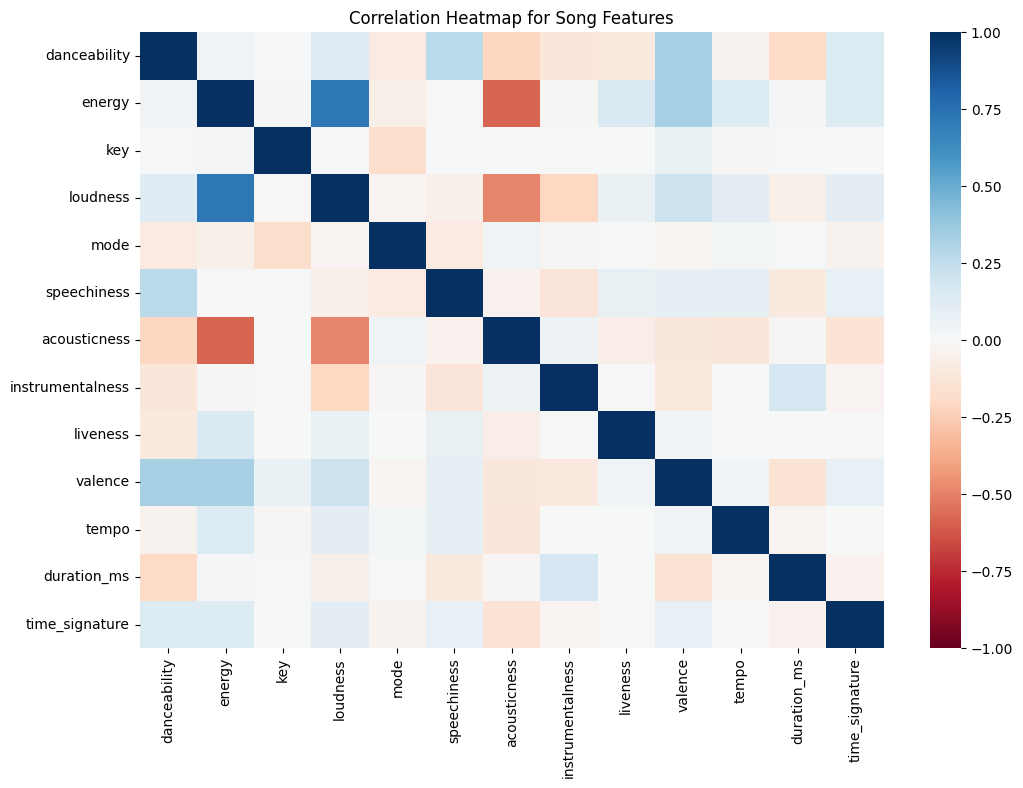

In [8]:
# Built correlation matrix using just song features.
corr_mat = spotify_realFinal.drop(['url', 'label'], axis = 1).corr()

# Visualized Correlation Heatmap.
fig, axes = plt.subplots(1, figsize= (12, 8))
sns.heatmap(ax = axes, data = corr_mat, vmin= -1, vmax=1, cmap= 'RdBu')
axes.set_title('Correlation Heatmap for Song Features')
plt.show()

Most of the features seem independent, but the ones that are clearly correlated make sense like loudness and energy being directly correlated or acousticness and energy being inversely correlated.

## Distributions of Features

Next, let's visualize the distributions of the features with some violin plots in the four labels:

* Label 0: Popular in both the US and the UK

* Label 1: Popular in only the US

* Label 2: Popular in only the UK

* Label 3: Not popular in either

### Label 0

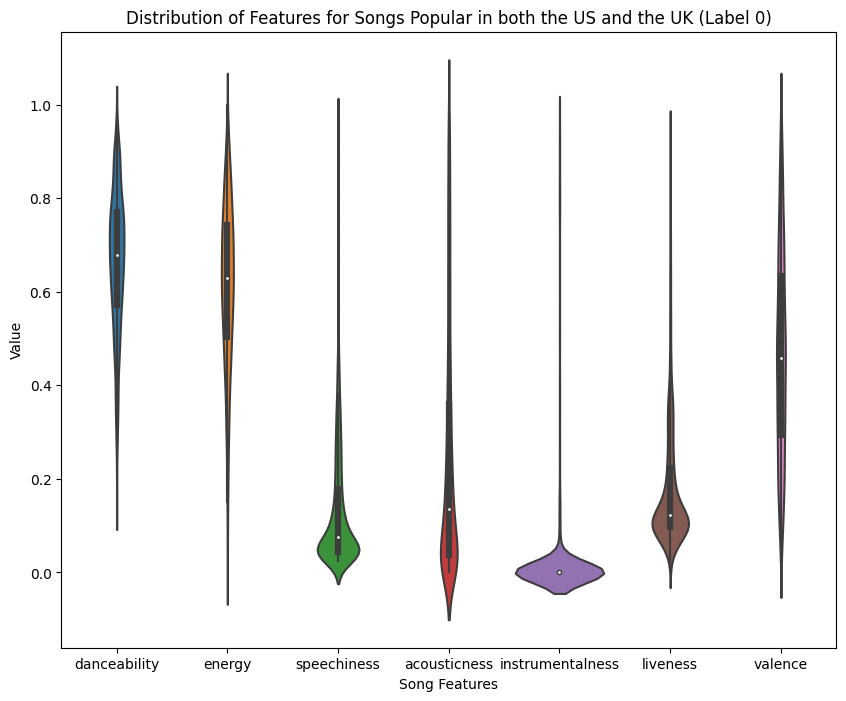

In [9]:
# Got the features of all songs popular in the US and UK.
vis_df = spotify_realFinal[spotify_realFinal['label'] == 0]

# Dropped features that are not relevant or aren't normalized.
vis_df = vis_df.drop(['url', 'label', 'time_signature', 'duration_ms', 'mode', 'tempo', 'key', 'loudness'], axis = 1)

# Created plot.
fig, axes = plt.subplots(1, figsize= (10, 8))
sns.violinplot(ax = axes, data = vis_df)
axes.set_title('Distribution of Features for Songs Popular in both the US and the UK (Label 0)')
axes.set_xlabel('Song Features')
axes.set_ylabel('Value')
plt.show()

For songs popular in both the US and UK, we can see that they are centered at a high danceability, relatively high energy, low speechiness, low acousticness, low liveness, and medium valence. This aligns with our expectations of what should be popular: catchy, mostly sung (not instrumental or spoken), and recorded (not live) songs. However, the spread of the songs is pretty thin suggesting there's a pretty high variability for what's popular in some features like danceability and energy.

### Label 1

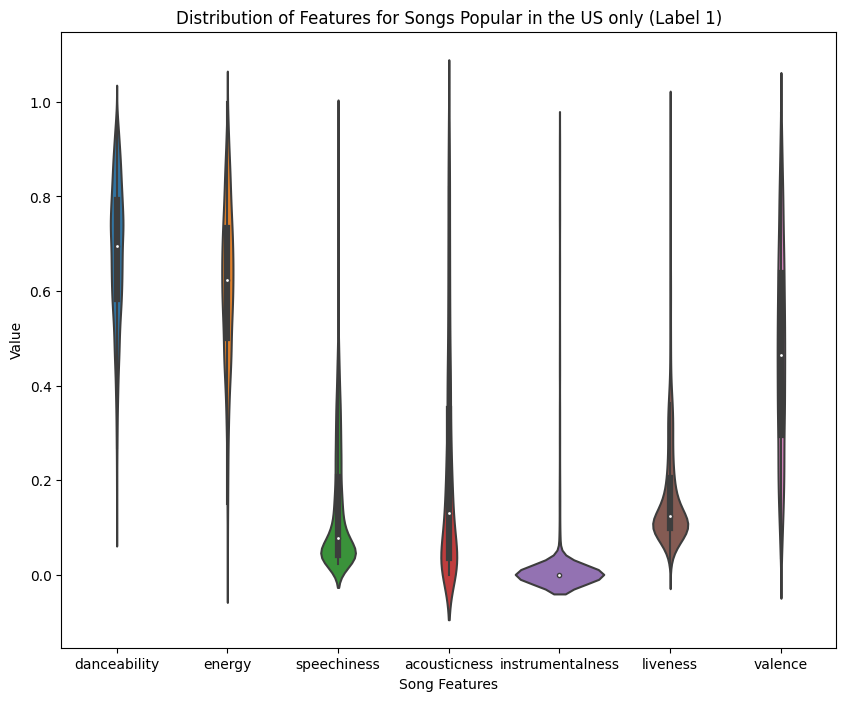

In [10]:
# Got the features of all songs popular in the US.
vis_df = spotify_realFinal[spotify_realFinal['label'] == 1]

# Dropped features that are not relevant or aren't normalized.
vis_df = vis_df.drop(['url', 'label', 'time_signature', 'duration_ms', 'mode', 'tempo', 'key', 'loudness'], axis = 1)

# Created plot.
fig, axes = plt.subplots(1, figsize= (10, 8))
sns.violinplot(ax = axes, data = vis_df)
axes.set_title('Distribution of Features for Songs Popular in the US only (Label 1)')
axes.set_xlabel('Song Features')
axes.set_ylabel('Value')
plt.show()

The distribution of features for songs popular in the US looks almost identical to the violin plot of songs for Label 0.

### Label 2

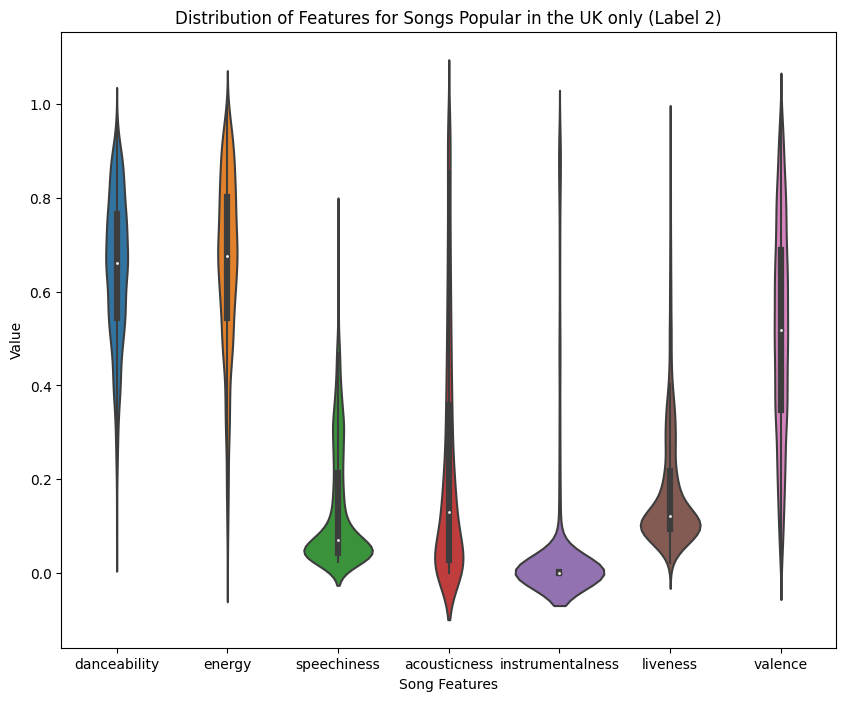

In [11]:
# Got the features of all songs popular in the UK.
vis_df = spotify_realFinal[spotify_realFinal['label'] == 2]

# Dropped features that are not relevant or aren't normalized.
vis_df = vis_df.drop(['url', 'label', 'time_signature', 'duration_ms', 'mode', 'tempo', 'key', 'loudness'], axis = 1)

# Created plot.
fig, axes = plt.subplots(1, figsize= (10, 8))
sns.violinplot(ax = axes, data = vis_df)
axes.set_title('Distribution of Features for Songs Popular in the UK only (Label 2)')
axes.set_xlabel('Song Features')
axes.set_ylabel('Value')
plt.show()

The distribution of features for songs popular in the UK looks slightly more concentrated around a mean than the songs in the above two plots. The songs that are popular in the UK seem to have a lower mean danceability but a higher energy. This could correspond to some genres like rock being more popular in the UK.

### Label 3

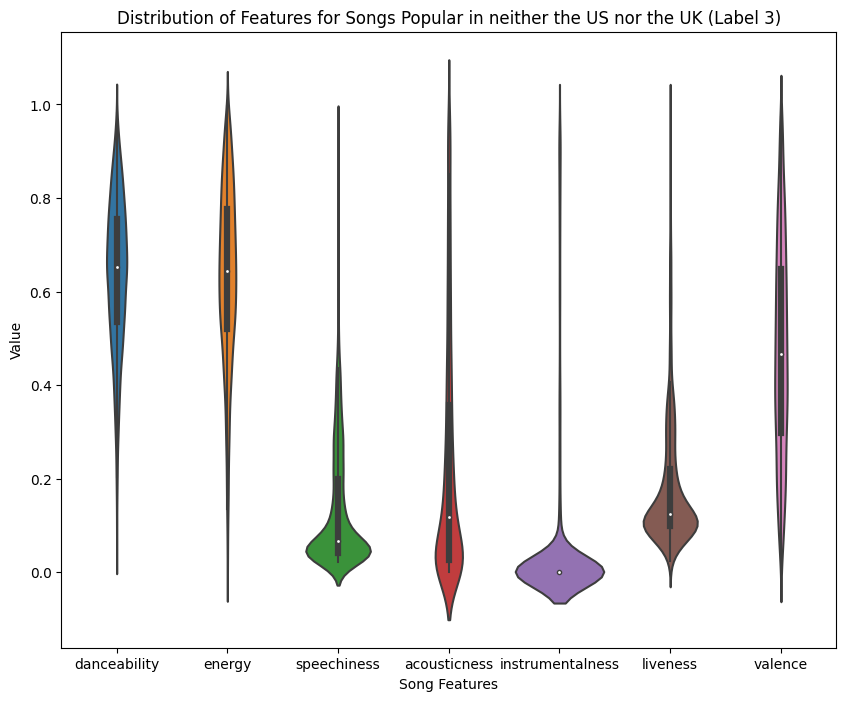

In [12]:
# Got the features of all songs not popular in the US or UK.
vis_df = spotify_realFinal[spotify_realFinal['label'] == 3]

# Dropped features that are not relevant or aren't normalized.
vis_df = vis_df.drop(['url', 'label', 'time_signature', 'duration_ms', 'mode', 'tempo', 'key', 'loudness'], axis = 1)

# Created plot.
fig, axes = plt.subplots(1, figsize= (10, 8))
sns.violinplot(ax = axes, data = vis_df)
axes.set_title('Distribution of Features for Songs Popular in neither the US nor the UK (Label 3)')
axes.set_xlabel('Song Features')
axes.set_ylabel('Value')
plt.show()

Overall, the songs not very popular in both countries aren't much different in their distribution of features from songs that are popular. This may be a problem for the classifier to recognize, as there does not seem to be too big of a difference between classes.

# MODELING

## Unsupervised Learning

###K-Means

First, we decided to conduct k-means clustering to uncover any clusters within the song features we could infer are certain genres.
To choose the number of clusters, we first made an Elbow Plot.

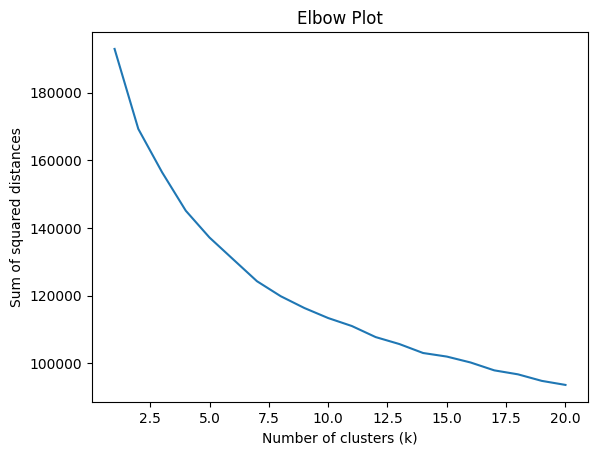

In [13]:
# Scaled the data in preparation for an Elbow Plot,
scaler = StandardScaler()
spotify_scaled = scaler.fit_transform(spotify_realFinal.drop(columns=['url', 'label']).dropna())

# Looked at K-Means for a range of k values.
sse = []
for k in range(1, 21):
    kmeans = KMeans(n_clusters=k, n_init = 10)
    kmeans.fit(spotify_scaled)
    sse.append(kmeans.inertia_)

# Ploted the SSE for each k value.
plt.plot(range(1, 21), sse)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Plot')
plt.show()

The Elbow Plot turned out to be quite inconclusive. This may be due to the fact that there is such a high range of k, so there is not a particularly clear elbow. For our clustering, we chose 5 as it is near a slightly visible convex kink in the Elbow Plot while not being too far towards the edges (there is also a similar kink around 2).

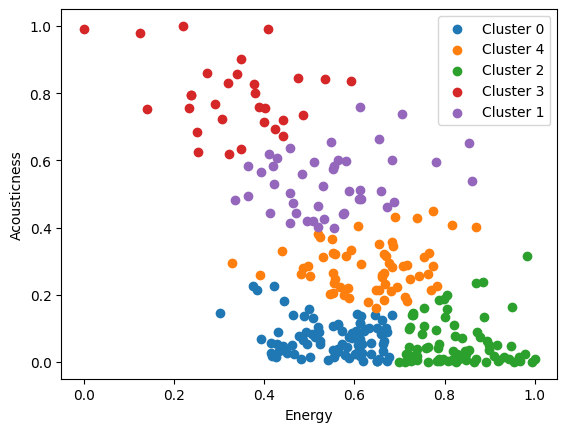

In [14]:
# Initialized a K-Means Clustering.
kmeans = KMeans(n_clusters=5, n_init = 10)

# Reduced the dataset size for the sake of visualization.
spotify_scaled = spotify_realFinal[spotify_realFinal.index % 50 == 0]

# Cleaning for to prepare data for scaling.
spotify_scaled_values = spotify_scaled.drop(columns = ['url','label']).values

# Initialize and use a scaler to normalize the data.
min_max_scaler = preprocessing.MinMaxScaler()
spotify_values_scaled = min_max_scaler.fit_transform(spotify_scaled_values)
spotify_values_scaled = pd.DataFrame(spotify_values_scaled)

# Fitted K-Means to two relevant features (Energy, and Acousticness).
kmeans.fit(spotify_values_scaled[[1, 6]])

# Added the cluster labels to the DataFrame.
spotify_values_scaled['cluster'] = kmeans.labels_

# Created a scatter plot with the clusters, Energy vs. Acousticness.
for cluster in spotify_values_scaled['cluster'].unique():
    plt.scatter(spotify_values_scaled.loc[spotify_values_scaled['cluster'] == cluster, 1],
                spotify_values_scaled.loc[spotify_values_scaled['cluster'] == cluster, 6],
                label='Cluster {}'.format(cluster))
plt.xlabel('Energy')
plt.ylabel('Acousticness')
plt.legend()
plt.show()

The clustering is not perfect, but the graph can clearly be seperated into five distinct sections by cluster.

* Cluster 0: medium acousticness and medium energy
* Cluster 1: low acousticness and high energy
* Cluster 2: low acoustiness, medium energy
* Cluster 3: high acoustiness, low energy
* Cluster 4: low acousticness, medium energy

Some of these clusters are more easily classed than others. For example, Cluster 1 likely includes a host of EDM dance songs, while Cluster 3 may be country or other non-electronic songs.

##Supervised Learning

###Logistic Regression

As a baseline model, we first decided to implement logistic regression for multi-class classification.

In [15]:
# Split data into train and test sets.
features = spotify_realFinal.drop(columns=['url', 'label']).dropna()
target = spotify_realFinal['label']
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size= .2, random_state = seed)

# Scaled features.
x_train = X_train.values
x_test = X_test.values
min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(x_train)
x_test_scaled = min_max_scaler.transform(x_test)
x_train_scaled_df = pd.DataFrame(x_train_scaled)
x_test_scaled_df = pd.DataFrame(x_test_scaled)

# Initialized Logistic Regression Classifier.
lm = LogisticRegression(multi_class='ovr', solver='liblinear')

# Trained Logistic Regression Classifier.
lm.fit(x_train_scaled_df, y_train)

# Got predictions from Logistic Regression Classifier.
y_pred = lm.predict(x_test_scaled_df)

# Evaluated the model on the test set.
log_acc = accuracy_score(y_pred, y_test)
print(f"Accuracy score: {log_acc:.3f}")

Accuracy score: 0.310


The accuracy of this model is not ideal. While it is much better than simply guessing (observed accuracy is 6 standard deviations above the mean compared to guessing), it is still not terrible accurate. Potential reasons for this will be discussed later in this writeup.

We also created a Confusion Matrix to better investigate the results of the model and give insight that a simple accuracy figure can't.

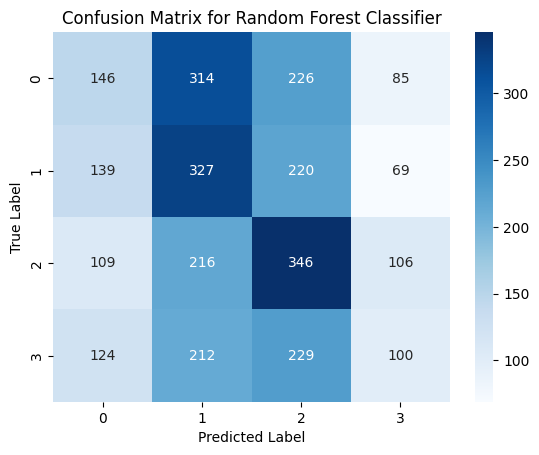

In [16]:
# Created and plotted confusion matrix.
cfm = confusion_matrix(y_test, y_pred)
sns.heatmap(cfm, annot=True, cmap='Blues', fmt = "g")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

Within each label (except 3), the model seems to predict the correct label more than any other individual label. However, since there are 3 incorrect labels for any given song, the accuracy is low. This model is strongest at identifying Label 2 songs (popular in the UK but not the US).

###Random Forest Classifier

We then turned to Random Forests to create another model. We chose to use this as one of our models because there are a lot of explanatory variables (we are taking in account all of the auditory features produced by Spotify's API). First, we explored what features should be considered for this classifier.

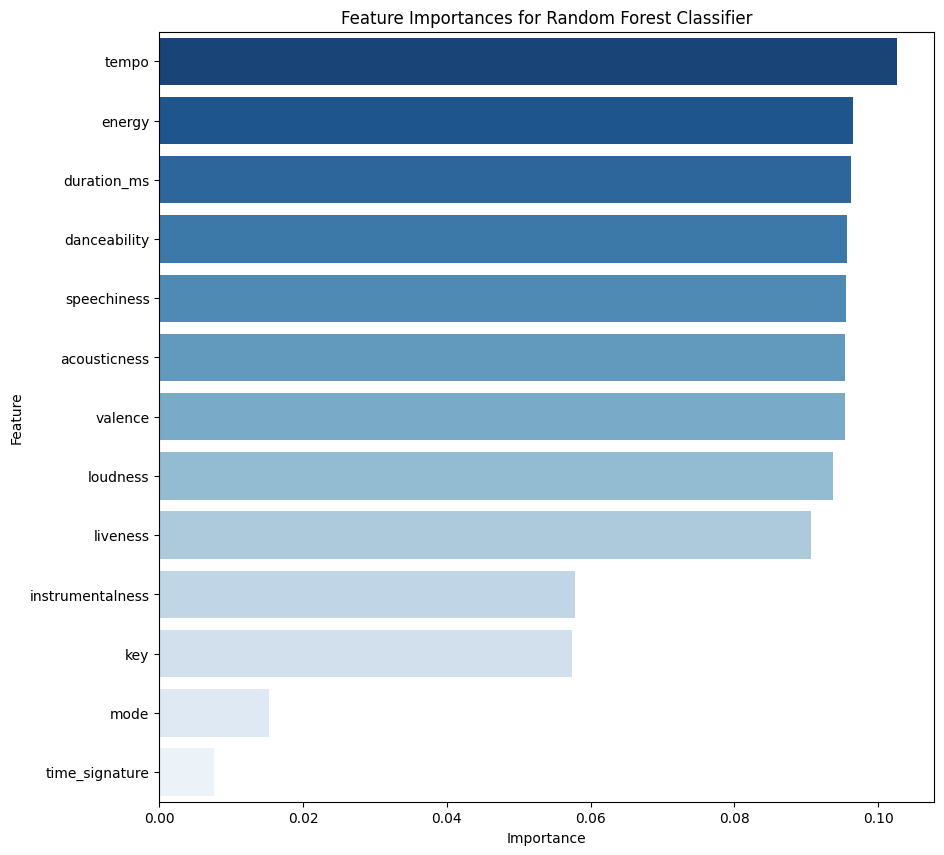

In [17]:
# Initialized a Random Forest Classifier.
RFC = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_depth=20,
                              min_samples_split=2, min_samples_leaf=1, random_state=42)

# Split the data into training and testing sets.
X = spotify_realFinal.drop(['url', 'label'], axis=1)
y = spotify_realFinal['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Trained the Random Forest Classifier.
RFC.fit(X_train, y_train)

# Set importances.
importances = RFC.feature_importances_

# Sorted feature importances in descending order.
indices = np.argsort(importances)[::-1]

# Rearranged feature names so they match the sorted feature importances.
names = [X.columns[i] for i in indices]

# Created plot.
plt.figure(figsize=(10,10))
sns.barplot(x=importances[indices], y=names, palette="Blues_r")
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest Classifier')
plt.show()

We noticed that a lot of cateogries carry relatively high importance. For the ones that don't, they all have relatively low variability (especially time_signature and mode). Thus, we decided to just use all of the features for our forest.

In [18]:
# Got predictions from the Random Forest Classifier.
y_pred = RFC.predict(X_test)

# Evaluated the model on the test set.
score = accuracy_score(y_pred, y_test)
print(f"Accuracy score: {score:.3f}")

Accuracy score: 0.397


Once again, not a super accurate score. However, it is much better than the logistic regression (observed accuracy is about 8.5 standard deviations above the mean when compared to logistic, and 15 when compared to guessing).

Below is the confusion matrix for the Random Forest Classifier.

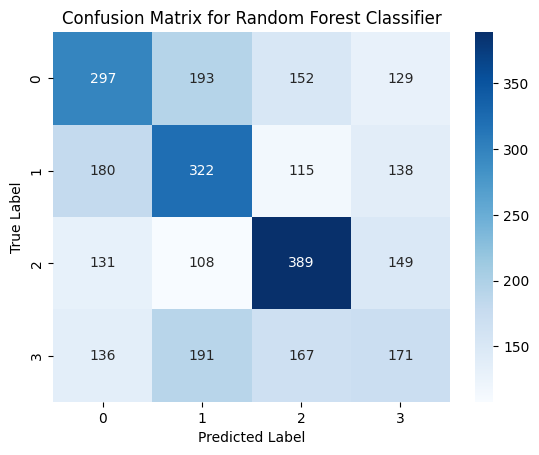

In [19]:
# Initialized Confusion Matrix.
cm = confusion_matrix(y_test, y_pred)

# Plotted Confusion Matrix with heatmap.
sns.heatmap(cm, annot=True, cmap='Blues', fmt = "g")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.show()

As can be seen in the matrix, the model does have some accuracy, with the heatmap showing decent results across Labels 0, 1, and especially 2. However, this comes with a weak showing in Label 3 and some inaccuracies across the board.

### Neural Network Model for Predicting the Label
We first began with a very simple neural network with a accuracy of `0.198` and the model below is our final attempt at raising our accuracy as much as possible.

In latest model, we added several hyperparameters to the neural network classifier, each of which positively affected the performance of the model:

* alpha is a regularization parameter that controls the degree of L2 regularization applied to the weights of the neural network. A higher alpha value will result in more regularization, which can help prevent overfitting.

* early_stopping is a boolean parameter that specifies whether to use early stopping to halt training when the validation score stops improving. Early stopping can help prevent overfitting.

* momentum is a parameter that controls the degree of momentum used in stochastic gradient descent optimization. A higher momentum value can help the optimizer escape local minima.

* param_grid is a dictionary of hyperparameters and the possible values they can take on. GridSearchCV will search over this grid to find the best combination of hyperparameters for the model. This way was much more efficient for us in terms of finding the best combination between a few different hyperparameters (not too many because it'd take too long to run).

At the end of it all, we were able to obtain an accurancy of `0.259`, which isn't optimal, but it's certainly a step up, and gratifying given the extensive work put into raising our accuracy.

Note: we realized that every time we tried new hyperparameters, it would take ~4 minutes to run the model, so adjusting the model was limited heavily by the time it took to train the model.

In [20]:
# Split data into features and labels.
X = spotify_realFinal.drop(['url', 'label'], axis=1)
y = spotify_realFinal['label']

# Split data into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Created a neural network classifier model.
model = MLPClassifier(hidden_layer_sizes=(100,50,25,), activation='relu', solver='adam',
                      alpha=0.0001, max_iter=250, random_state=42, early_stopping=True,
                      learning_rate_init=0.01)

# Defined a grid of hyperparameters to search over.
param_grid = {
    'hidden_layer_sizes': [(100,50,25), (50,25), (25,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate_init': [0.001, 0.01, 0.1],
}

# Used GridSearchCV to search over the hyperparameter grid and find the best model.
grid = GridSearchCV(model, param_grid=param_grid)
grid.fit(X_train, y_train)

# Printed the best hyperparameters and the performance of the best model.
print('Best hyperparameters:', grid.best_params_)
y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

Best hyperparameters: {'activation': 'tanh', 'hidden_layer_sizes': (25,), 'learning_rate_init': 0.001, 'solver': 'adam'}
              precision    recall  f1-score   support

           0       0.26      1.00      0.41       771
           1       0.00      0.00      0.00       755
           2       0.00      0.00      0.00       777
           3       0.00      0.00      0.00       665

    accuracy                           0.26      2968
   macro avg       0.06      0.25      0.10      2968
weighted avg       0.07      0.26      0.11      2968



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# Tested the accuracy of the model.

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy score:', accuracy)

Accuracy score: 0.25977088948787064


Unfortunately, this observed accuracy score is just about one standard deviation above that of guessing, meaning it is not a statistically significant difference. The F1 scores show an interesting story, with the model only having predictive authority on Label 0.

We then created a function to predict what label (popularity) a song would be when given a `'song_url'`.

Note: you will need Spotify API developer toolkit credentials to run this function since it pulls Spotify's song features using the inputted url. Depending on throttling of the current account being used this may or may not run.

In [22]:
# Created predict label function that returns a prediction of the label when given a song url.

def predict_label(song_url):
    # Get information about the track using the Spotipy API's 'track' method.
    track_info = sp.track(song_url)

    # Extract the track ID from the track information.
    track_id = track_info['id']

    # Get the audio features for the track using 'audio_features' method.
    audio_features = sp.audio_features(track_id)

    # Convert audio features to a DataFrame.
    sample_song = pd.DataFrame(audio_features)

    # Drop irrelevant columns from the DataFrame.
    sample_song.drop(['type', 'id', 'uri', 'track_href', 'analysis_url'], axis=1, inplace=True)

    # Use the pre-trained model to predict the label of the sample song.
    predicted_label = grid.predict(sample_song)

    # Return the predicted label as a string.
    return f'The predicted label of the sample song is: {predicted_label}'

In [23]:
predict_label('https://open.spotify.com/track/4cOdK2wGLETKBW3PvgPWqT?si=ec6d70a75a334948')

'The predicted label of the sample song is: [0]'

![picture](https://drive.google.com/uc?=view=export&id=1ZFnvlDg5m5hYDha6rDuZSWaZgepkhYFL)

Here, we predicted whether or not 'Never Gonna Give You Up' by Rick Astley would be a popular song in the US and/or UK. Our function predicted it to have the label 0, meaning it would be popular in both the US and UK, which is correct in the context of reality.


(Sorry for Rick Rolling you!).

# REFLECTION

For our models, it is clear that the Random Forest Classifier was the most effective. Not only did it have the highest empirical accuracy, but it also got "closer" a lot more than the other two. This may be because Random Forests perform best with a lot of explanatory variables, which we had.

However, model accuracy as a whole across this dataset was not what we were aiming for. We think that a lot of it can be attributed down to the way our data is distributed. Every song on the list has done very well for itself, and it's difficult to differenciate between the top 0.01% and 0.02%. Additionally, the margins are spread fairly thin by the nature of this type of Machine Learning. A song in the 49th percentile of appearances is labeled as "not popular" even though it likely holds no statistical significance over a song in the 50th percentile. This made it harder for our models to determine labels for these edge cases. Also, it's possible that the US and UK have similar enough music tastes that would make it more difficult for a machine to differenciate between the two. Finally, there are many external factors that cannot be accounted for in a model like this which may drive songs to the top. These include things like social media platforms, world circumstances, and the general music taste at the time (which very well could've shifted over 5 years).

As an experiment, we first homongenized the data between the two countries and set anything over 6 appearances in either country as one label and anything under as another. Running the same Random Forest Classifier as we used for our actual data, accuracy came back at 60%. Compared to the 50% from a straight guess, this is an improvement, but still not great. We then took the homogenized data and set one label to be the top 25% and one to be the bottom 25%. This returned a slightly higher accuracy of 65%.

Therefore, it may be possible that there is no particularly strong relation between auditory characteristics of a song and how it performs once it gets to the top charts.